# Music generation VAES

In [50]:
import numpy as np
from pathlib import Path
import IPython
from keras import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, History
import numpy as np
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Conv1D, \
    MaxPooling1D, Flatten, BatchNormalization, LeakyReLU, Lambda
from keras.optimizers import Adam, RMSprop
from keras.engine.topology import Input
from keras import backend as K
import cv2
import matplotlib.pyplot as plt

## I Signal Processing

In [58]:
# Data imports and processing

x_train, x_val = [], []
p_train = Path("data/train")
p_val = Path("data/val")
data_train = list(p_train.glob("*.jpg"))
data_val = list(p_val.glob("*.jpg"))
data_train = [str(path) for path in data_train]
data_val = [str(path) for path in data_val]

for path in data_train:
    im = cv2.imread(path)
    im = im.astype('float32')
    im = cv2.resize(im, (20, 20)) / 255
    im = np.expand_dims(im, axis=0)
    x_train.append(im)
    
for path in data_val:
    im = cv2.imread(path)
    im = im.astype('float32')
    im = cv2.resize(im, (20, 20)) / 255
    im = np.expand_dims(im, axis=0)
    x_val.append(im)

x_train = np.array(x_train)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

x_val = np.array(x_val)
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))


In [ ]:
# Preprocessing audio



## II Model 

In [80]:
# Essayer différentes activations, différentes profondeurs, différents types de couches

class VAE:

    def __init__(self, batch_size, epochs, original_dim=1200, 
                 latent_dim=100, intermediate_dim=100):
        self.batch_size = batch_size
        self.epochs = epochs
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.encoder = self.make_encoder()
        self.sampling_layer = self.make_sampling_layer()
        self.decoder = self.make_decoder()
        self.vae_model = self.make_vae(self.sampling_layer, self.encoder, self.decoder)

    def fit(self, x_train, x_val):
        """
        Train the Vae using the Adam Optimizer. 
        """
        
        early_stopping = EarlyStopping(monitor='val_loss',
                                       patience=3,
                                       mode='min')

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=1, min_lr=0.001)
        
        #xent_loss = self.original_dim * metrics.binary_crossentropy(
        #K.flatten(x_train), K.flatten(self.x_decoded))
        #kl_loss = - 0.5 * K.sum(1 + self.z_sigma - K.square(self.z_mean) - K.exp(self.z_sigma), axis=-1)
        #vae_loss = K.mean(xent_loss + kl_loss)
        #self.vae_model.add_loss(vae_loss)
        self.vae_model.compile(optimizer="Adam", loss="categorical_crossentropy")
        self.vae_model.fit(x_train, x_train,
                           validation_data=(x_val, x_val), 
                           epochs=self.epochs,
                           batch_size=self.batch_size,
                           callbacks=[reduce_lr, early_stopping])
        
    def predict(self, z_test):
        """
        At test time, we evaluate the VAE's ability to generate a new sample. We can remove the 
        encoder as there is no test image. We sample z from a N(0, I), pass it through the decoder.
        There are no good quantitative metrics, only visual appreciation.
        """
        
        return self.decoder.predict(z_test)
     
    def make_encoder(self):
        """
        Transform the input into a distribution, composed of the mean and the variance
        
        Returns:
        model -- the encoder model with the object as input and the z_mean and z_sigma 
        as output
        """
        
        enc_input = Input(shape=(self.original_dim,))
        # We can try without the intermediate dim, directly relating input to latent z
        x = Dense(self.intermediate_dim, activation='relu')(enc_input)
        self.z_mean = Dense(self.latent_dim)(x)
        self.z_sigma = Dense(self.latent_dim)(x)
        model = Model(enc_input, outputs = [self.z_mean, self.z_sigma])
        
        return model
    
    def make_decoder(self):
        """
        Decodes the latent vector z and match it with the original output
        
        Returns:
        model -- the decoder model with the latent variable as input and the original object as output
        """
        
        dec_input = Input(shape=(self.latent_dim,))
        x = Dense(self.intermediate_dim, activation='relu')(dec_input)
        x = Dense(self.original_dim, activation='sigmoid')(x)
        model = Model(dec_input, x)
        
        return model
    
    def sampling(self, params):
        """
        Function that uses the learned mean and sigma from the data and return the latent vector z
        This is the re-parametrization trick. Instead of taking (z -> N(z_mean, z_sigma)), we take
        (epsilon -> N(0, I) and z = z_mean + z_sigma * epsilon). 
        Arguments:
        z_mean -- the learned mean
        z_sigma -- the learned standard deviation
        """
        
        z_mean, z_sigma = params
        epsilon = K.random_normal((self.batch_size, self.latent_dim), 0.0, 1.0)
        z = z_mean + K.exp(z_sigma / 2) * epsilon

        return z
        
    def make_sampling_layer(self):
        sampling_layer = Lambda(self.sampling, output_shape=(self.latent_dim,))
        return sampling_layer
    
    def make_vae(self, sampling_layer, encoder, decoder):
        """
        Compile the entire variational auto-encoder
        """
        
        input_ = Input(shape=(self.original_dim,))
        z_mean, z_sigma = encoder(input_)
        z = sampling_layer([z_mean, z_sigma])
        self.x_decoded = decoder(z)
        model = Model(input_, self.x_decoded)
    
        return model  
    
vae = VAE(1, 50)
vae.fit(x_train, x_val)

Train on 93 samples, validate on 25 samples
Epoch 1/50
93/93 [==============================] - 2s 16ms/step - loss: 3647.8588 - val_loss: 3277.0770
Epoch 2/50
93/93 [==============================] - 0s 3ms/step - loss: 3632.8180 - val_loss: 3261.9715
Epoch 3/50
93/93 [==============================] - 0s 4ms/step - loss: 3624.1692 - val_loss: 3258.2367
Epoch 4/50
93/93 [==============================] - 0s 4ms/step - loss: 3620.0379 - val_loss: 3255.3545
Epoch 5/50
93/93 [==============================] - 0s 3ms/step - loss: 3617.6957 - val_loss: 3253.5731
Epoch 6/50
93/93 [==============================] - 0s 3ms/step - loss: 3612.7221 - val_loss: 3252.8782
Epoch 7/50
93/93 [==============================] - 0s 3ms/step - loss: 3607.8030 - val_loss: 3252.0064
Epoch 8/50
93/93 [==============================] - 0s 3ms/step - loss: 3605.8571 - val_loss: 3245.8635
Epoch 9/50
93/93 [==============================] - 0s 3ms/step - loss: 3600.0858 - val_loss: 3242.3874
Epoch 10/50
93/93 [

In [81]:
z_test = np.random.randn(1,100)
pred = vae.predict(z_test)
pred = pred.reshape((20, 20, 3))

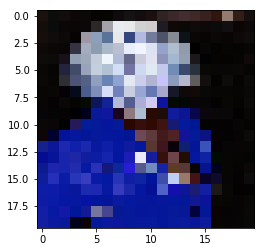

In [82]:
plt.imshow(x_train[0].reshape(20, 20, 3))
plt.show()

# See if we have time to talk about conditional VAEs (CVAEs) and GAN as an extension

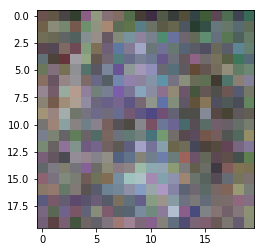

In [83]:
plt.imshow(pred)
plt.show()

## III Results